In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from pytrends.request import TrendReq

%matplotlib inline

In [65]:
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

#### Check TensorFlow

In [66]:
print(tf.__version__)

2.3.0


### Get VTI history

In [67]:
vti = yf.Ticker("VTI")
vti_hist = vti.history(period="max")

In [68]:
vti_close_hist = vti_hist.Close

In [69]:
# this is a good reminder of what day you pulled the history!!!!
vti_close_hist.tail()

Date
2020-08-11    168.90
2020-08-12    171.16
2020-08-13    171.03
2020-08-14    170.98
2020-08-17    171.79
Name: Close, dtype: float64

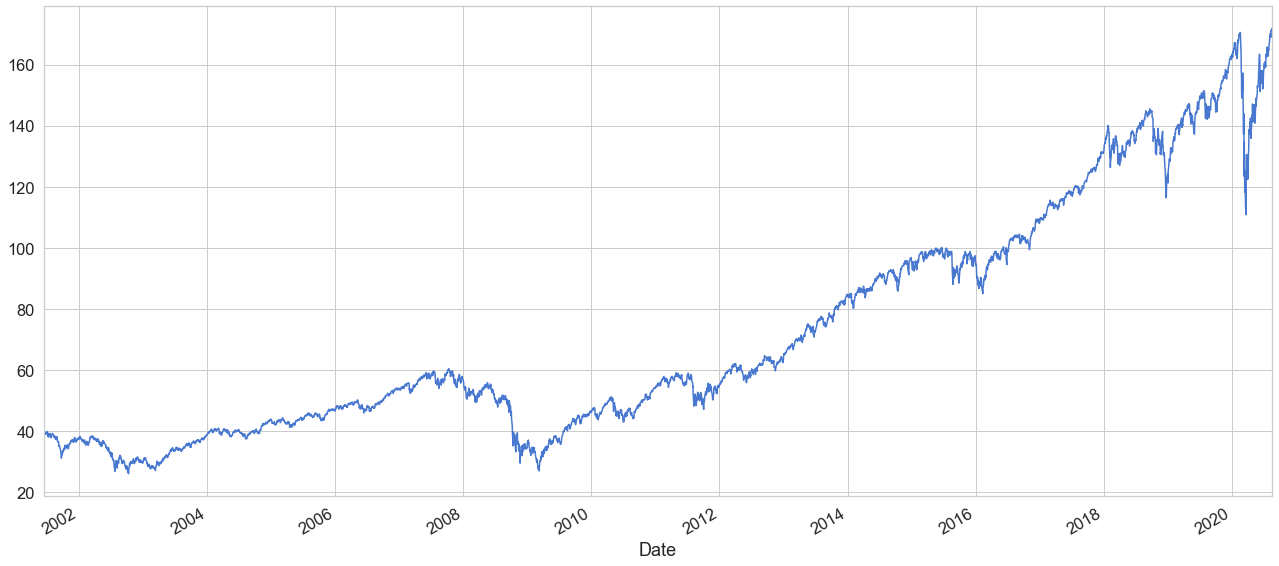

In [70]:
vti_close_hist.plot()

#### Get top 10 holding in VTI


##### * Top 10 holdings were NOT found programatically. This info has yet to be found in the vti object *

In [71]:
microsoft = yf.Ticker('MSFT').history(period="max")
apple = yf.Ticker('AAPL').history(period="max")
amazon = yf.Ticker('AMZN').history(period="max")
facebook = yf.Ticker('FB').history(period="max")
alphabetA = yf.Ticker('GOOGL').history(period="max")
alphabetC = yf.Ticker('GOOG').history(period="max")
johnson = yf.Ticker('JNJ').history(period="max")
berkshire = yf.Ticker('BRK-B').history(period="max")
visa = yf.Ticker('V').history(period="max")
proctor = yf.Ticker('PG').history(period="max")

In [72]:
# In cases of dividends being reported, during that day the day is listed twice causing a duplicate index.
# droping nan's should get rid of of the duplicate row
holdings = [microsoft, apple, amazon, facebook, alphabetA, alphabetC, johnson, berkshire, visa, proctor]
for holding in holdings:
    holding.dropna(inplace=True)

#### Get DOW

In [73]:
dow = yf.Ticker('DJIA').history(period="max")

#### Get Gooogle Trends data

In [74]:
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(['vti'], timeframe='all')
trend_df = pytrends.interest_over_time()

#### Upsample Google trend data to daily

In [75]:
# upsample: every day in month will have the monthly average
g_trends_daily = trend_df.resample('D').ffill()

In [76]:
last_full_month_value = g_trends_daily.iloc[-2].vti

In [77]:
g_trends_daily.rename(columns={'vti': 'avg_searches', 'date': 'Date'}, inplace=True)

In [78]:
g_trends_daily.drop(columns='isPartial', inplace=True)

In [79]:
g_trends_daily

,avg_searches
date,
2004-01-01,54
2004-01-02,54
2004-01-03,54
2004-01-04,54
2004-01-05,54
...,...
2020-07-28,57
2020-07-29,57
2020-07-30,57


#### Combine holdings into DF

In [107]:
df = pd.concat([vti_hist.Close.rename('vti'),
                 microsoft.Close.rename('msft'),
                 apple.Close.rename('appl'),
                 amazon.Close.rename('amzn'),
                 facebook.Close.rename('fb'),
                 alphabetA.Close.rename('google'),
                 alphabetC.Close.rename('googlb'),
                 johnson.Close.rename('jnj'),
                 berkshire.Close.rename('brk'),
                 visa.Close.rename('visa'),
                 proctor.Close.rename('pg'),
                 dow.Close.rename('dow')], join='outer', axis=1)


#### left join google trends (to accomodate for gtrends including weekends)

In [108]:
df = df.join(g_trends_daily['avg_searches'].rename('gtrnd'), how='left')

#### truncate to dates when vti is in existance

In [109]:
df = df.loc['2001-06-15':]

#### Special Cleaning for Google Trends

In [110]:
# fill the month of august with the values from the last full month
df.gtrnd.iloc[-30::].fillna(last_full_month_value, inplace=True)

In [111]:
df.tail(10)

,vti,msft,appl,amzn,fb,google,googlb,jnj,brk,visa,pg,dow,gtrnd
Date,,,,,,,,,,,,,
2020-08-04,167.62,213.29,437.87,3138.83,249.83,1473.30,1464.97,147.22,200.24,192.00,133.79,26828.47,57.0
2020-08-05,168.84,212.94,439.46,3205.03,249.12,1479.09,1473.61,148.40,203.62,195.80,133.44,27201.52,57.0
2020-08-06,169.66,216.35,454.79,3225.00,265.28,1504.95,1500.10,147.55,205.02,198.47,132.71,27386.98,57.0
2020-08-07,169.80,212.48,444.45,3167.46,268.44,1498.37,1494.49,148.60,209.48,196.06,133.55,27433.48,57.0
2020-08-10,170.27,208.25,450.91,3148.16,263.00,1496.82,1496.10,148.03,212.58,196.49,134.10,27791.44,57.0
2020-08-11,168.90,203.38,437.50,3080.67,256.13,1480.54,1480.32,146.97,212.66,197.47,133.23,27686.91,57.0
2020-08-12,171.16,209.19,452.04,3162.24,259.89,1507.24,1506.62,149.66,213.24,198.44,135.46,27976.84,57.0
2020-08-13,171.03,208.70,460.04,3161.02,261.30,1516.65,1518.45,148.00,211.98,197.58,135.78,27896.72,57.0
2020-08-14,170.98,208.90,459.63,3148.02,261.24,1504.63,1507.73,148.24,210.96,196.64,135.10,27931.02,57.0


In [112]:
df.gtrnd.fillna(df.gtrnd.mean(), inplace=True)

### For holdings that didn't exist yet, fill NAs with its minimum price

In [113]:
for col in df.columns:
    df[col].fillna(df[col].min(), inplace=True)

## Modeling

#### Train Test Split

In [114]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
df_copy = df.copy()
train, test = df_copy.iloc[0:train_size], df_copy.iloc[train_size:len(df)]
print(len(train), len(test))

4340 483


In [115]:
# select only feature columns
f_columns = df.columns.drop('vti')

# scale all data
f_transformer = RobustScaler()
vti_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
vti_transformer = vti_transformer.fit(train[['vti']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['vti'] = vti_transformer.transform(train[['vti']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['vti'] = vti_transformer.transform(test[['vti']])

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [119]:
train.head(1)

,vti,msft,appl,amzn,fb,google,googlb,jnj,brk,visa,pg,dow,gtrnd
Date,,,,,,,,,,,,,
2001-06-15,-0.323774,-0.004956,-0.317547,-0.387312,0.0,-0.557933,-0.569675,-0.339414,-0.515493,-0.165015,-0.944047,-0.249945,0.165544


In [120]:
#offsets the y values (target values) to be the time_step ammount infront of each row
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [121]:
time_steps = 1

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.vti, time_steps)
X_test, y_test = create_dataset(test, test.vti, time_steps)

print(X_train.shape, y_train.shape)

(4339, 1, 13) (4339,)


In [122]:
print(X_test.shape, y_test.shape)

(482, 1, 13) (482,)


In [123]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [124]:
history = model.fit(
    X_train, y_train, 
    epochs=7, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/7
123/123 [==============================] - 1s 6ms/step - loss: 0.0191 - val_loss: 0.0281
Epoch 2/7
123/123 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0134
Epoch 3/7
123/123 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0198
Epoch 4/7
123/123 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0207
Epoch 5/7
123/123 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0174
Epoch 6/7
123/123 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0250
Epoch 7/7
123/123 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0227


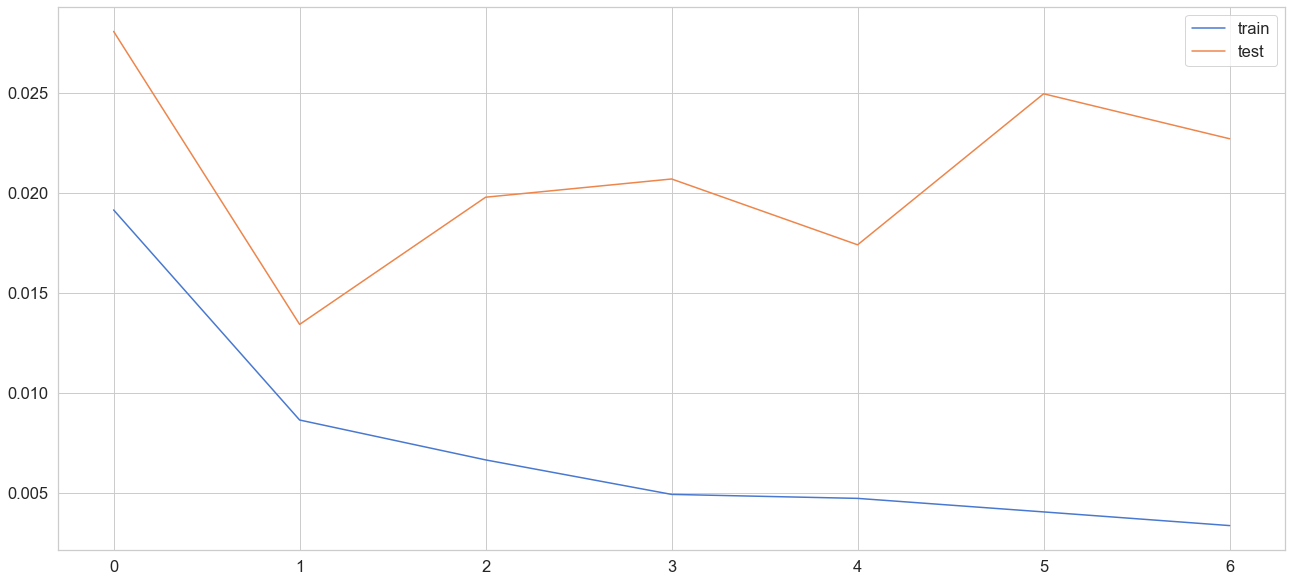

In [125]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [126]:
y_pred = model.predict(X_test)

In [127]:
y_train_inv = vti_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = vti_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = vti_transformer.inverse_transform(y_pred)

In [128]:
print("RMSE = ", np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten())))
print("MAE = ", mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten()))

RMSE =  18.055612914650307
MAE =  15.360825391587383


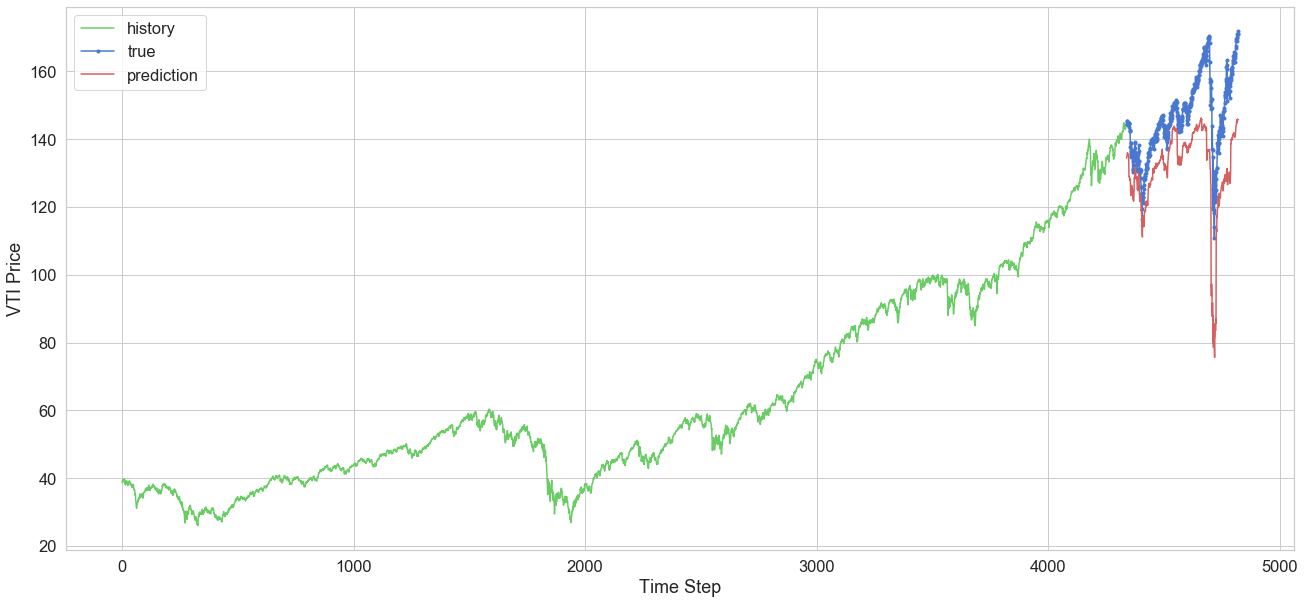

In [129]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.savefig('images/hist_preds.png')
plt.show();

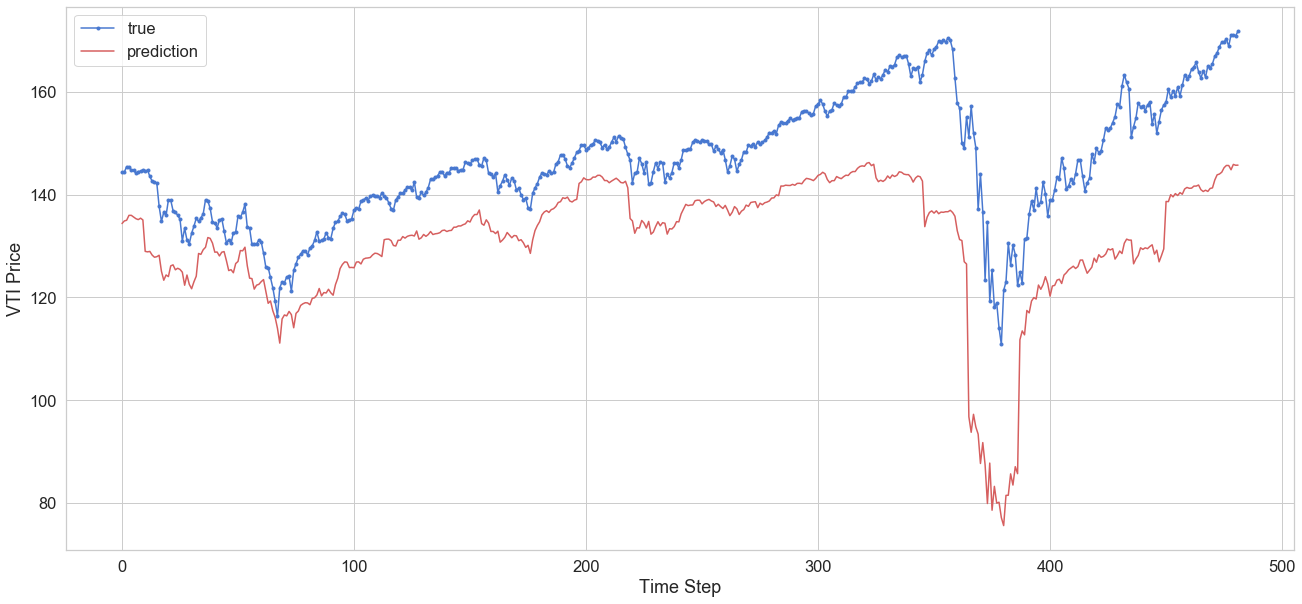

In [130]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.savefig('images/lstm_preds_vs_true.png')
plt.show();


In [131]:
def get_buy_sell(prices):
    outcomes=[]
    for index, price in enumerate(prices[1:]):
        if price > prices[index] :
            outcomes.append(1)
        else:
            outcomes.append(0)
    return outcomes

In [132]:
y_test_outcomes = get_buy_sell(y_test_inv.flatten())

In [133]:
y_pred_outcomes = get_buy_sell(y_pred_inv.flatten())

In [134]:
confusion_matrix(y_test_outcomes, y_pred_outcomes)

array([[ 87, 124],
       [121, 149]])

In [135]:
def calc_returns(pred_outcomes, true_prices, investment):
    capital = investment
    in_market = False
    for index, price in enumerate(true_prices[:-1]):
        if pred_outcomes[index] == 1:
            if in_market == False:
                holdings = capital/price
                capital = 0
                in_market = True
        if pred_outcomes[index] == 0:
            if in_market:
                capital = holdings*price
                holdings = 0
                in_market = False
    return holdings*true_prices[-1] or capital

#### Returns if I had started my trading strategy from the start of the tset period

In [136]:
calc_returns(y_pred_outcomes, y_test_inv.flatten(), 1000)

936.2821618410773

#### Returns if I had bought at the beginning of the test period and just held

In [137]:
(1000/y_test_inv.flatten()[0])*y_test_inv.flatten()[-1]

1190.0110834026045

## Train model on full dataset

In [194]:
# select only feature columns
f_columns = df.columns.drop('vti')
full_train = df.copy()

# scale all data
funct_full_transformer = RobustScaler()
vti_full_transformer = RobustScaler()

funct_full_transformer = funct_full_transformer.fit(df[f_columns].to_numpy())
vti_transformer = vti_full_transformer.fit(df[['vti']])

In [195]:
full_train.loc[:, f_columns] = funct_full_transformer.transform(df[f_columns].to_numpy())
full_train['vti'] = vti_full_transformer.transform(df[['vti']])

In [225]:
y_test_full = full_train.iloc[1+int(len(df) * 0.9):].vti

In [196]:
time_steps = 1

# reshape to [samples, time_steps, n_features]
X_full_train, y_full_train = create_dataset(full_train, full_train.vti, time_steps)

print(X_full_train.shape, y_full_train.shape)

(4822, 1, 13) (4822,)


In [197]:
full_model = keras.Sequential()
full_model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_full_train.shape[1], X_full_train.shape[2])
    )
  )
)
full_model.add(keras.layers.Dropout(rate=0.2))
full_model.add(keras.layers.Dense(units=1))
full_model.compile(loss='mean_squared_error', optimizer='adam')

In [198]:
full_history = full_model.fit(
    X_full_train, y_full_train, 
    epochs=7, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/7
136/136 [==============================] - 1s 6ms/step - loss: 0.0161 - val_loss: 0.0172
Epoch 2/7
136/136 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0244
Epoch 3/7
136/136 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0099
Epoch 4/7
136/136 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0096
Epoch 5/7
136/136 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0092
Epoch 6/7
136/136 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0102
Epoch 7/7
136/136 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0122


In [199]:
full_train.tail(1)

,vti,msft,appl,amzn,fb,google,googlb,jnj,brk,visa,pg,dow,gtrnd
Date,,,,,,,,,,,,,
2020-08-17,2.137237,6.975827,4.384304,5.927835,3.04319,2.3251,2.423061,2.032741,1.510248,2.925196,2.588861,-0.821752,2.5


### Make a prediction for tomorrow

In [200]:
tomorrow_pred = full_model.predict(full_train.iloc[-1].values.reshape(1, 1, -1))

In [201]:
# transform back to dollar value
vti_full_transformer.inverse_transform(tomorrow_pred)

array([[142.90923]], dtype=float32)

In [202]:
y_full_pred = full_model.predict(X_test)

In [230]:
y_test_inv = vti_full_transformer.inverse_transform(np.array(y_test_full).reshape(1, -1))
y_full_pred_inv = vti_full_transformer.inverse_transform(y_full_pred)

In [231]:
len(y_test_inv.flatten())

482

In [232]:
compare = pd.DataFrame()
compare['preds'] = y_full_pred_inv.flatten()
compare['true'] = y_test_inv.flatten()

In [233]:
compare

,preds,true
0,169.350311,144.36
1,170.263763,144.38
2,170.193314,145.49
3,170.950577,145.35
4,170.572418,144.82
...,...,...
477,186.523941,168.90
478,186.197235,171.16
479,186.779907,171.03
480,186.489075,170.98


In [234]:
print("RMSE = ", np.sqrt(mean_squared_error(y_test_inv.flatten(), y_full_pred_inv.flatten())))
print("MAE = ", mean_absolute_error(y_test_inv.flatten(), y_full_pred_inv.flatten()))

RMSE =  24.28936035089044
MAE =  23.24528685510406


In [235]:
y_full_pred_outcomes = get_buy_sell(y_full_pred_inv.flatten())

In [236]:
confusion_matrix(y_test_outcomes, y_full_pred_outcomes)

array([[ 88, 123],
       [125, 145]])

#### Returns if I had started my trading strategy from the start of the tset period

In [237]:
calc_returns(y_full_pred_outcomes, y_test_inv.flatten(), 1000)

952.8575915328397

#### Returns if I had bought at the beginning of the test period and just held

In [238]:
(1000/y_test_inv.flatten()[0])*y_test_inv.flatten()[-1]

1190.0110834026045